In [ ]:
!pip install transformers
!pip install peft

In [108]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd

from torch.optim.lr_scheduler import StepLR     # for dynamic learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score
from transformers import Wav2Vec2ForSequenceClassification, AdamW
from peft import get_peft_model, LoraConfig, TaskType
from transformers import Wav2Vec2ForSequenceClassification
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from peft import get_peft_model, LoraConfig, TaskType
from transformers import Wav2Vec2ForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
from transformers import Wav2Vec2ForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score


import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 no

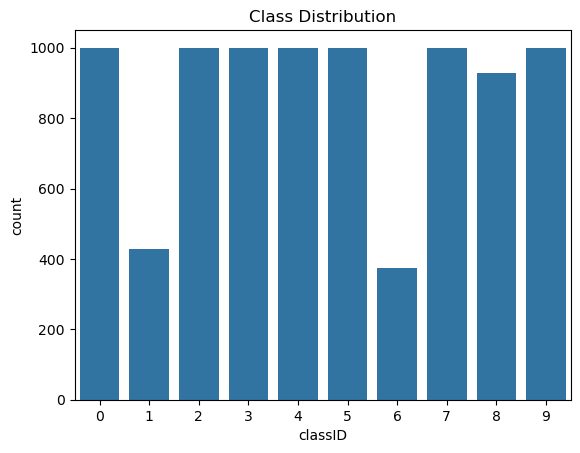

In [10]:
df = pd.read_csv('urbansound8k/metadata/UrbanSound8K.csv')
print(df.head())
print(df.info())
sns.countplot(x=df['classID'])
plt.title('Class Distribution')
plt.show()


In [15]:
audio_files = []
labels = []

label_dict = {}
with open("urbansound8k/metadata/UrbanSound8K.csv") as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        label_dict[row[0]] = row[7]

for fold in range(1, 11):  # UrbanSound8K contains data in 10 folds   relative path ---> UrbanSound8K/audio
    fold_path = f"UrbanSound8K/audio/fold{fold}/"
    for filename in os.listdir(fold_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(fold_path, filename)
            data, sr = librosa.load(file_path, sr=None)
            audio_files.append((data, sr))
            labels.append(label_dict[filename])


## Zero Shot Classification using Wave2Vec2

### Loading the Pretrained Wave2Vec2 with classification Head

In [6]:
# Load pretrained Wave2Vec2 model with a classification head
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=10)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# Define target sampling rate
TARGET_SR = 16000

/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prepating the dataset and predicting


In [24]:
le = LabelEncoder()
y = le.fit_transform(labels)  # Encode string labels into integers

In [28]:
y[0:200]

array([2, 6, 0, 0, 7, 7, 4, 7, 5, 4, 3, 7, 7, 8, 7, 5, 4, 8, 9, 4, 2, 7,
       8, 7, 8, 8, 9, 2, 7, 3, 9, 6, 8, 9, 9, 5, 7, 7, 8, 9, 5, 4, 2, 7,
       4, 0, 3, 7, 2, 0, 3, 7, 4, 2, 0, 3, 0, 7, 0, 0, 7, 4, 3, 4, 8, 7,
       4, 5, 3, 2, 7, 7, 2, 7, 8, 6, 9, 7, 2, 7, 4, 8, 3, 7, 2, 4, 7, 8,
       7, 5, 2, 9, 3, 4, 8, 7, 7, 9, 4, 2, 7, 7, 0, 0, 0, 3, 3, 0, 3, 0,
       7, 0, 0, 3, 3, 7, 2, 7, 7, 9, 8, 3, 5, 5, 7, 4, 9, 9, 3, 7, 7, 3,
       8, 9, 9, 8, 7, 4, 5, 7, 5, 7, 6, 7, 8, 7, 3, 6, 9, 0, 0, 7, 1, 3,
       2, 6, 3, 0, 7, 3, 0, 6, 5, 1, 3, 3, 3, 2, 3, 3, 7, 4, 8, 8, 7, 9,
       9, 3, 5, 7, 5, 1, 1, 7, 7, 8, 8, 3, 9, 7, 3, 7, 5, 7, 2, 5, 3, 8,
       9, 8])

In [29]:
# Preprocess audio files and get zero-shot predictions
zero_shot_preds = []
true_labels = []

for i, (data, sr) in enumerate(audio_files):
    # Resample if necessary
    if sr != TARGET_SR:
        data = librosa.resample(data, orig_sr=sr, target_sr=TARGET_SR)
    
    # Preprocess with the processor
    inputs = processor(data, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
    
    # Perform inference without fine-tuning
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_label = torch.argmax(logits, dim=-1).item()
        zero_shot_preds.append(predicted_label)
    
    # Store true label
    true_labels.append(y[i])


### Evaluating Zero Shot Classification

In [30]:
zero_shot_accuracy = accuracy_score(true_labels, zero_shot_preds)
zero_shot_precision = precision_score(true_labels, zero_shot_preds, average="macro")
zero_shot_recall = recall_score(true_labels, zero_shot_preds, average="macro")

# Display results
print("Zero-Shot Classification:")
print(f"Accuracy: {zero_shot_accuracy:.2f}")
print(f"Precision: {zero_shot_precision:.2f}")
print(f"Recall: {zero_shot_recall:.2f}")


Zero-Shot Classification:
Accuracy: 0.14
Precision: 0.07
Recall: 0.17


/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fine Tuning with LORA

### Preparing the data for fine tuning

In [34]:
# Split audio_files and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(audio_files, y, test_size=0.2, random_state=42)

print(f"Number of training samples: {len(X_train)}")
print(f"Number of test samples: {len(X_test)}")

Number of training samples: 6985
Number of test samples: 1747


In [66]:
# Example of a properly formatted dataset
class UrbanSoundDataset(Dataset):
    def __init__(self, audio_files, labels, processor, target_sr=16000, max_length=64000):
        self.audio_files = audio_files
        self.labels = labels
        self.processor = processor
        self.target_sr = target_sr
        self.max_length = max_length  # Maximum length to pad/truncate audio

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        data, sr = self.audio_files[idx]
        
        # Resample audio to target sample rate
        if sr != self.target_sr:
            data = librosa.resample(data, orig_sr=sr, target_sr=self.target_sr)
        
        # Pad or truncate audio to max_length
        if len(data) > self.max_length:
            data = data[:self.max_length]
        else:
            data = np.pad(data, (0, self.max_length - len(data)), mode='constant')
        
        # Preprocess audio and create input
        inputs = self.processor(data, sampling_rate=self.target_sr, return_tensors="pt", padding=True)
        return {
            "input_values": inputs["input_values"].squeeze(0),  # Ensure correct format
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
    }



In [114]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(audio_files, y, test_size=0.2, random_state=42)

# Define UrbanSoundDataset and DataLoader
train_dataset = UrbanSoundDataset(X_train, y_train, processor)
test_dataset = UrbanSoundDataset(X_test, y_test, processor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Validate the DataLoader
print("Validating DataLoader...")
for batch in train_loader:
    print(f"Input Values Shape: {batch['input_values'].shape}")  # Should be [batch_size, max_length]
    print(f"Labels Shape: {batch['labels'].shape}")  # Should be [batch_size]
    break  # Check only the first batch


Validating DataLoader...
Input Values Shape: torch.Size([8, 64000])
Labels Shape: torch.Size([8])


In [72]:
batch = next(iter(train_loader))
print(batch.keys())  # Should include 'input_values' and 'labels'
print(batch["input_values"].shape)  # Expected: [batch_size, max_length]
print(batch["labels"].shape)  # Expected: [batch_size]


dict_keys(['input_values', 'labels'])
torch.Size([8, 64000])
torch.Size([8])


### Fine tuning using LORA

In [113]:
# Testing the base model :
# Load the base model without LoRA
base_model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=10)
base_model.to(device)

# Test a forward pass with the base model
outputs = base_model(input_values=batch["input_values"].to(device), labels=batch["labels"].to(device))
print(outputs)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SequenceClassifierOutput(loss=tensor(2.2925, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0100, -0.0136,  0.0152,  0.0107,  0.0368, -0.0037, -0.0478, -0.0381,
          0.0099,  0.0266],
        [-0.0430, -0.0375, -0.0329, -0.0108,  0.0164, -0.0601, -0.0472, -0.0272,
         -0.0067, -0.0025],
        [-0.0783, -0.0334, -0.0290, -0.0038,  0.0368, -0.0750, -0.0618, -0.0062,
         -0.0010, -0.0207],
        [-0.0185, -0.0049, -0.0316, -0.0127,  0.0087, -0.0181, -0.0125, -0.0306,
          0.0088,  0.0042],
        [-0.0420, -0.0136, -0.0389, -0.0099,  0.0130, -0.0452, -0.0278, -0.0258,
          0.0175,  0.0212],
        [-0.0191, -0.0148, -0.0074,  0.0081,  0.0171, -0.0138, -0.0220, -0.0370,
          0.0217,  0.0228],
        [-0.0536, -0.0182, -0.0079,  0.0038,  0.0241, -0.0523, -0.0286, -0.0231,
          0.0051, -0.0055],
        [-0.0533, -0.0440, -0.0340, -0.0151,  0.0185, -0.0712, -0.0576, -0.0244,
         -0.0185,  0.0031]], grad_fn=<AddmmBackward0>), hidden_states=None,

In [85]:
for name, module in base_model.named_modules():
    print(name)



wav2vec2
wav2vec2.feature_extractor
wav2vec2.feature_extractor.conv_layers
wav2vec2.feature_extractor.conv_layers.0
wav2vec2.feature_extractor.conv_layers.0.conv
wav2vec2.feature_extractor.conv_layers.0.activation
wav2vec2.feature_extractor.conv_layers.0.layer_norm
wav2vec2.feature_extractor.conv_layers.1
wav2vec2.feature_extractor.conv_layers.1.conv
wav2vec2.feature_extractor.conv_layers.1.activation
wav2vec2.feature_extractor.conv_layers.2
wav2vec2.feature_extractor.conv_layers.2.conv
wav2vec2.feature_extractor.conv_layers.2.activation
wav2vec2.feature_extractor.conv_layers.3
wav2vec2.feature_extractor.conv_layers.3.conv
wav2vec2.feature_extractor.conv_layers.3.activation
wav2vec2.feature_extractor.conv_layers.4
wav2vec2.feature_extractor.conv_layers.4.conv
wav2vec2.feature_extractor.conv_layers.4.activation
wav2vec2.feature_extractor.conv_layers.5
wav2vec2.feature_extractor.conv_layers.5.conv
wav2vec2.feature_extractor.conv_layers.5.activation
wav2vec2.feature_extractor.conv_layers

In [86]:
target_modules = [
    "wav2vec2.encoder.layers.0.attention.k_proj",
    "wav2vec2.encoder.layers.0.attention.q_proj",
    "wav2vec2.encoder.layers.0.attention.v_proj",
    "wav2vec2.encoder.layers.0.attention.out_proj",
    "wav2vec2.encoder.layers.0.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.0.feed_forward.output_dense",
    "wav2vec2.encoder.layers.1.attention.k_proj",
    "wav2vec2.encoder.layers.1.attention.q_proj",
    "wav2vec2.encoder.layers.1.attention.v_proj",
    "wav2vec2.encoder.layers.1.attention.out_proj",
    "wav2vec2.encoder.layers.1.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.1.feed_forward.output_dense",
    "wav2vec2.encoder.layers.2.attention.k_proj",
    "wav2vec2.encoder.layers.2.attention.q_proj",
    "wav2vec2.encoder.layers.2.attention.v_proj",
    "wav2vec2.encoder.layers.2.attention.out_proj",
    "wav2vec2.encoder.layers.2.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.2.feed_forward.output_dense",
    "wav2vec2.encoder.layers.3.attention.k_proj",
    "wav2vec2.encoder.layers.3.attention.q_proj",
    "wav2vec2.encoder.layers.3.attention.v_proj",
    "wav2vec2.encoder.layers.3.attention.out_proj",
    "wav2vec2.encoder.layers.3.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.3.feed_forward.output_dense",
    "wav2vec2.encoder.layers.4.attention.k_proj",
    "wav2vec2.encoder.layers.4.attention.q_proj",
    "wav2vec2.encoder.layers.4.attention.v_proj",
    "wav2vec2.encoder.layers.4.attention.out_proj",
    "wav2vec2.encoder.layers.4.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.4.feed_forward.output_dense",
    "wav2vec2.encoder.layers.5.attention.k_proj",
    "wav2vec2.encoder.layers.5.attention.q_proj",
    "wav2vec2.encoder.layers.5.attention.v_proj",
    "wav2vec2.encoder.layers.5.attention.out_proj",
    "wav2vec2.encoder.layers.5.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.5.feed_forward.output_dense",
    "wav2vec2.encoder.layers.6.attention.k_proj",
    "wav2vec2.encoder.layers.6.attention.q_proj",
    "wav2vec2.encoder.layers.6.attention.v_proj",
    "wav2vec2.encoder.layers.6.attention.out_proj",
    "wav2vec2.encoder.layers.6.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.6.feed_forward.output_dense",
    "wav2vec2.encoder.layers.7.attention.k_proj",
    "wav2vec2.encoder.layers.7.attention.q_proj",
    "wav2vec2.encoder.layers.7.attention.v_proj",
    "wav2vec2.encoder.layers.7.attention.out_proj",
    "wav2vec2.encoder.layers.7.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.7.feed_forward.output_dense",
    "wav2vec2.encoder.layers.8.attention.k_proj",
    "wav2vec2.encoder.layers.8.attention.q_proj",
    "wav2vec2.encoder.layers.8.attention.v_proj",
    "wav2vec2.encoder.layers.8.attention.out_proj",
    "wav2vec2.encoder.layers.8.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.8.feed_forward.output_dense",
    "wav2vec2.encoder.layers.9.attention.k_proj",
    "wav2vec2.encoder.layers.9.attention.q_proj",
    "wav2vec2.encoder.layers.9.attention.v_proj",
    "wav2vec2.encoder.layers.9.attention.out_proj",
    "wav2vec2.encoder.layers.9.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.9.feed_forward.output_dense",
    "wav2vec2.encoder.layers.10.attention.k_proj",
    "wav2vec2.encoder.layers.10.attention.q_proj",
    "wav2vec2.encoder.layers.10.attention.v_proj",
    "wav2vec2.encoder.layers.10.attention.out_proj",
    "wav2vec2.encoder.layers.10.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.10.feed_forward.output_dense",
    "wav2vec2.encoder.layers.11.attention.k_proj",
    "wav2vec2.encoder.layers.11.attention.q_proj",
    "wav2vec2.encoder.layers.11.attention.v_proj",
    "wav2vec2.encoder.layers.11.attention.out_proj",
    "wav2vec2.encoder.layers.11.feed_forward.intermediate_dense",
    "wav2vec2.encoder.layers.11.feed_forward.output_dense",
]


/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 51,722 || all params: 94,622,868 || trainable%: 0.0547


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


Training Epoch 1: 100%|██████████| 874/874 [1:13:58<00:00,  5.08s/batch, Batch Loss=2.09]   


Training Loss: 2.1501
Validation Loss: 2.0672


/var/folders/vx/9cf9tngn6qs563bg7n_qlt5m0000gn/T/ipykernel_12195/571521404.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model

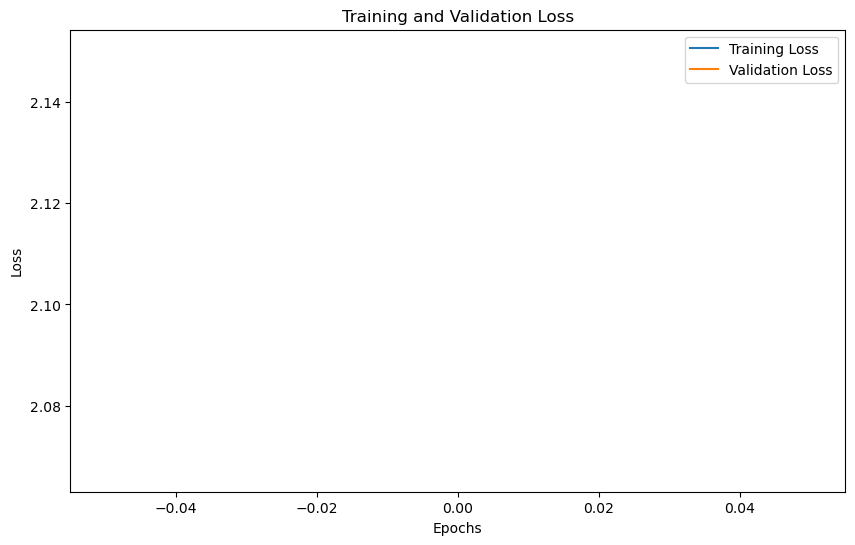

In [119]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=10)
model.to(device)

# LoRA Configuration
from peft import LoraConfig, get_peft_model, TaskType

target_modules = [
    "wav2vec2.encoder.layers.0.attention.k_proj",
    "wav2vec2.encoder.layers.0.attention.q_proj",
    "wav2vec2.encoder.layers.0.attention.v_proj",
    "wav2vec2.encoder.layers.0.attention.out_proj",
]

config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=target_modules,
)

model = get_peft_model(base_model, config)
model.to(device)
# Verifying trainable parameters
model.print_trainable_parameters() 

model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=10)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Early Stopping
early_stopping_patience = 3
best_loss = float('inf')
patience_counter = 0

# Lists to store training and validation loss
train_losses = []
val_losses = []

# Halving Learning rate after every epoch   (can change the step size)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Training loop with early stopping
num_epochs = 1  # Can Increase epochs for meaningful results
val_loader = test_loader  # Rename for clarity

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    print(f"Epoch {epoch + 1}/{num_epochs}")

    with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", unit="batch") as pbar:
        for batch in pbar:
            inputs = {
                "input_values": batch["input_values"].to(device),
                "labels": batch["labels"].to(device),
            }
            outputs = model(
                input_values=inputs["input_values"],
                labels=inputs["labels"],
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})

    train_losses.append(epoch_loss / len(train_loader))
    print(f"Training Loss: {train_losses[-1]:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {
                "input_values": batch["input_values"].to(device),
                "labels": batch["labels"].to(device),
            }
            outputs = model(
                input_values=inputs["input_values"],
                labels=inputs["labels"],
            )
            val_loss += outputs.loss.item()
            val_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            val_labels.extend(inputs["labels"].cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


### Debugging

In [100]:
print(f"Input Values Shape: {batch['input_values'].shape}")
print(f"Labels Shape: {batch['labels'].shape}")

print(model.forward.__doc__)  # Check the forward method signature

model.print_trainable_parameters()

print(model.state_dict().keys())



Input Values Shape: torch.Size([8, 64000])
Labels Shape: torch.Size([8])
None
trainable params: 1,329,674 || all params: 95,900,820 || trainable%: 1.3865
odict_keys(['base_model.model.wav2vec2.masked_spec_embed', 'base_model.model.wav2vec2.feature_extractor.conv_layers.0.conv.weight', 'base_model.model.wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight', 'base_model.model.wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias', 'base_model.model.wav2vec2.feature_extractor.conv_layers.1.conv.weight', 'base_model.model.wav2vec2.feature_extractor.conv_layers.2.conv.weight', 'base_model.model.wav2vec2.feature_extractor.conv_layers.3.conv.weight', 'base_model.model.wav2vec2.feature_extractor.conv_layers.4.conv.weight', 'base_model.model.wav2vec2.feature_extractor.conv_layers.5.conv.weight', 'base_model.model.wav2vec2.feature_extractor.conv_layers.6.conv.weight', 'base_model.model.wav2vec2.feature_projection.layer_norm.weight', 'base_model.model.wav2vec2.feature_projection.layer_no

### Evaluating the Model

In [120]:
# Evaluate on the test set
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {
            "input_values": batch["input_values"].to(device),
            "labels": batch["labels"].to(device),
        }
        outputs = model(
            input_values=inputs["input_values"],
            labels=inputs["labels"],
        )
        test_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        test_labels.extend(inputs["labels"].cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average="macro")
recall = recall_score(test_labels, test_preds, average="macro")

# Create a table
results = pd.DataFrame({
    "Classifier": ["Wav2Vec2 + LoRA"],
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall]
})

print(results)

        Classifier  Accuracy  Precision    Recall
0  Wav2Vec2 + LoRA  0.195192   0.069279  0.161142


/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Result Table

In [ ]:
# results = pd.DataFrame({
#     "Method": ["Layer-Freezing Fine-Tuning", "LoRA Fine-Tuning"],
#     "Accuracy": [layer_freezing_accuracy * 100, lora_accuracy * 100],
#     "Precision": [layer_freezing_precision * 100, lora_precision * 100],
#     "Recall": [layer_freezing_recall * 100, lora_recall * 100]
# })

# # Display results
# print(results)


### Coparison between ZSC Model and Fine Tuned Model

In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Evaluate Zero-Shot Model
zero_shot_preds, zero_shot_labels = [], []
base_model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = {
            "input_values": batch["input_values"].to(device),
        }
        outputs = model(
            input_values=inputs["input_values"]
        )
        zero_shot_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        zero_shot_labels.extend(batch["labels"].cpu().numpy())

# Zero-Shot Metrics
zs_accuracy = accuracy_score(zero_shot_labels, zero_shot_preds)
zs_precision = precision_score(zero_shot_labels, zero_shot_preds, average="macro")
zs_recall = recall_score(zero_shot_labels, zero_shot_preds, average="macro")
zs_f1 = f1_score(zero_shot_labels, zero_shot_preds, average="macro")

# Evaluate Fine-Tuned Model
fine_tuned_preds, fine_tuned_labels = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = {
            "input_values": batch["input_values"].to(device),
            "labels": batch["labels"].to(device),
        }
        outputs = model(
            input_values=inputs["input_values"],
            labels=inputs["labels"],
        )
        fine_tuned_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        fine_tuned_labels.extend(batch["labels"].cpu().numpy())

# Fine-Tuned Metrics
ft_accuracy = accuracy_score(fine_tuned_labels, fine_tuned_preds)
ft_precision = precision_score(fine_tuned_labels, fine_tuned_preds, average="macro")
ft_recall = recall_score(fine_tuned_labels, fine_tuned_preds, average="macro")
ft_f1 = f1_score(fine_tuned_labels, fine_tuned_preds, average="macro")

# Combine Results into a Table
comparison_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Zero-Shot Model": [zs_accuracy, zs_precision, zs_recall, zs_f1],
    "Fine-Tuned Model": [ft_accuracy, ft_precision, ft_recall, ft_f1],
})

# Display the Table
print(comparison_table)


/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      Metric  Zero-Shot Model  Fine-Tuned Model
0   Accuracy         0.195192          0.195192
1  Precision         0.069279          0.069279
2     Recall         0.161142          0.161142
3   F1-Score         0.075213          0.075213


/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Saving the fine tuned model

In [ ]:
# Save the fine-tuned model and processor
model.save_pretrained("./fine_tuned_wav2vec2")
processor.save_pretrained("./fine_tuned_wav2vec2")

print("Fine-tuned model and processor saved successfully!")


### To load the model you can use this 

`from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor`

`model = Wav2Vec2ForSequenceClassification.from_pretrained("./fine_tuned_wav2vec2")`
`processor = Wav2Vec2Processor.from_pretrained("./fine_tuned_wav2vec2")`

`print("Fine-tuned model and processor loaded successfully!")`


END OF ASSIGNMENT 